In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
import speclet.io
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.managers.cache_manager import PosteriorManager
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval
HDI_LBL = f"{int(100*HDI_PROB)}%"

## Hierarchical NB model analysis

### Setup

#### Model

In [5]:
speclet_hnb = HierarchcalNegativeBinomialModel()

In [6]:
pm = PosteriorManager(
    id="hierarchical-nb_PYMC3_MCMC", cache_dir=speclet.io.models_dir()
)
assert pm.posterior_cache_exists, "Posterior cache does not exist."
hnb_trace = pm.get(from_file=True)
hnb_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### Data

In [7]:
data_manager = CrisprScreenDataManager(
    data_file=speclet.io.DataFile.DEPMAP_CRC_BONE_SUBSAMPLE
)

In [8]:
counts_data = data_manager.get_data()

In [9]:
valid_data = speclet_hnb.data_processing_pipeline(counts_data)
valid_data

sgrna                  replicate_id       lfc  \
0     AGCTGAGCGCAGGGACCGGG  LS513-311Cas9_RepA_p6_batch2 -0.020788   
1     CTACTAGACTTCCTGCCGGC  LS513-311Cas9_RepA_p6_batch2 -0.666070   
2     AAACTTGCTGACGTGCCTGG  LS513-311Cas9_RepA_p6_batch2 -0.130231   
3     AACGATCTCATCCTCAAAAG  LS513-311Cas9_RepA_p6_batch2  0.198958   
4     AAGTTCCTCTGAAGTTCGCA  LS513-311Cas9_RepA_p6_batch2 -0.182191   
...                    ...                           ...       ...   
2183   TTGTGTCGTTCGCCGCACA                   EW22_c907R1  0.244659   
2184   TTGTGTCTACTGTTCTAGA                   EW22_c907R1 -0.116722   
2185   TTTAAACGACTGTCAAACC                   EW22_c907R1  0.558014   
2186   TTTGAGAAGTCCCCCCTGC                   EW22_c907R1 -3.103909   
2187   TTTGTTGGGACCAATGGAA                   EW22_c907R1 -0.360181   

                 p_dna_batch   genome_alignment hugo_symbol  screen  \
0                          2    chr1_27012633_-      TENT5B   broad   
1                          2    chr1_27006754_-      TENT5B   broad   
2                          2    chr4_52628042_-       USP46   broad   
3                          2  chr11_107549790_+      ALKBH8   broad   
4                          2   chr2_241704672_-        ING5   broad   
...                      ...                ...         ...     ...   
2183  CRISPR_C6596666.sample  chr13_113429046_-     ADPRHL1  sanger   
2184  CRISPR_C6596666.sample   chr12_25225698_+        KRAS  sanger   
2185  CRISPR_C6596666.sample    chr4_46065548_+      GABRG1  sanger   
2186  CRISPR_C6596666.sample   chr19_17862113_+      RPL18A  sanger   
2187  CRISPR_C6596666.sample    chr6_42573875_+        UBR2  sanger   

      multiple_hits_on_gene sgrna_target_chr  sgrna_target_pos  ...  \
0                      True                1          27012633  ...   
1                      True                1          27006754  ...   
2                      True                4          52628042  ...   
3                      True               11         107549790  ...   
4                      True                2         241704672  ...   
...                     ...              ...               ...  ...   
2183                   True               13         113429046  ...   
2184                   True               12          25225698  ...   
2185                   True                4          46065548  ...   
2186                   True               19          17862113  ...   
2187                   True                6          42573875  ...   

     is_mutated  copy_number     lineage  primary_or_metastasis  is_male  \
0         False     0.961139  colorectal                primary     True   
1         False     0.961139  colorectal                primary     True   
2         False     0.952543  colorectal                primary     True   
3         False     0.960147  colorectal                primary     True   
4         False     0.973700  colorectal                primary     True   
...         ...          ...         ...                    ...      ...   
2183      False     0.785368        bone                    NaN      NaN   
2184      False     1.155020        bone                    NaN      NaN   
2185      False     0.962042        bone                    NaN      NaN   
2186      False     1.146916        bone                    NaN      NaN   
2187      False     1.026703        bone                    NaN      NaN   

       age counts_final_total counts_initial_total  counts_final_rpm  \
0     63.0           35176093         1.072163e+06          4.837834   
1     63.0           35176093         1.072163e+06          6.344539   
2     63.0           35176093         1.072163e+06          7.908101   
3     63.0           35176093         1.072163e+06         12.570358   
4     63.0           35176093         1.072163e+06          9.727518   
...    ...                ...                  ...               ...   
2183   NaN           28939388         1.101090e+06       

### Analyzing model posterior

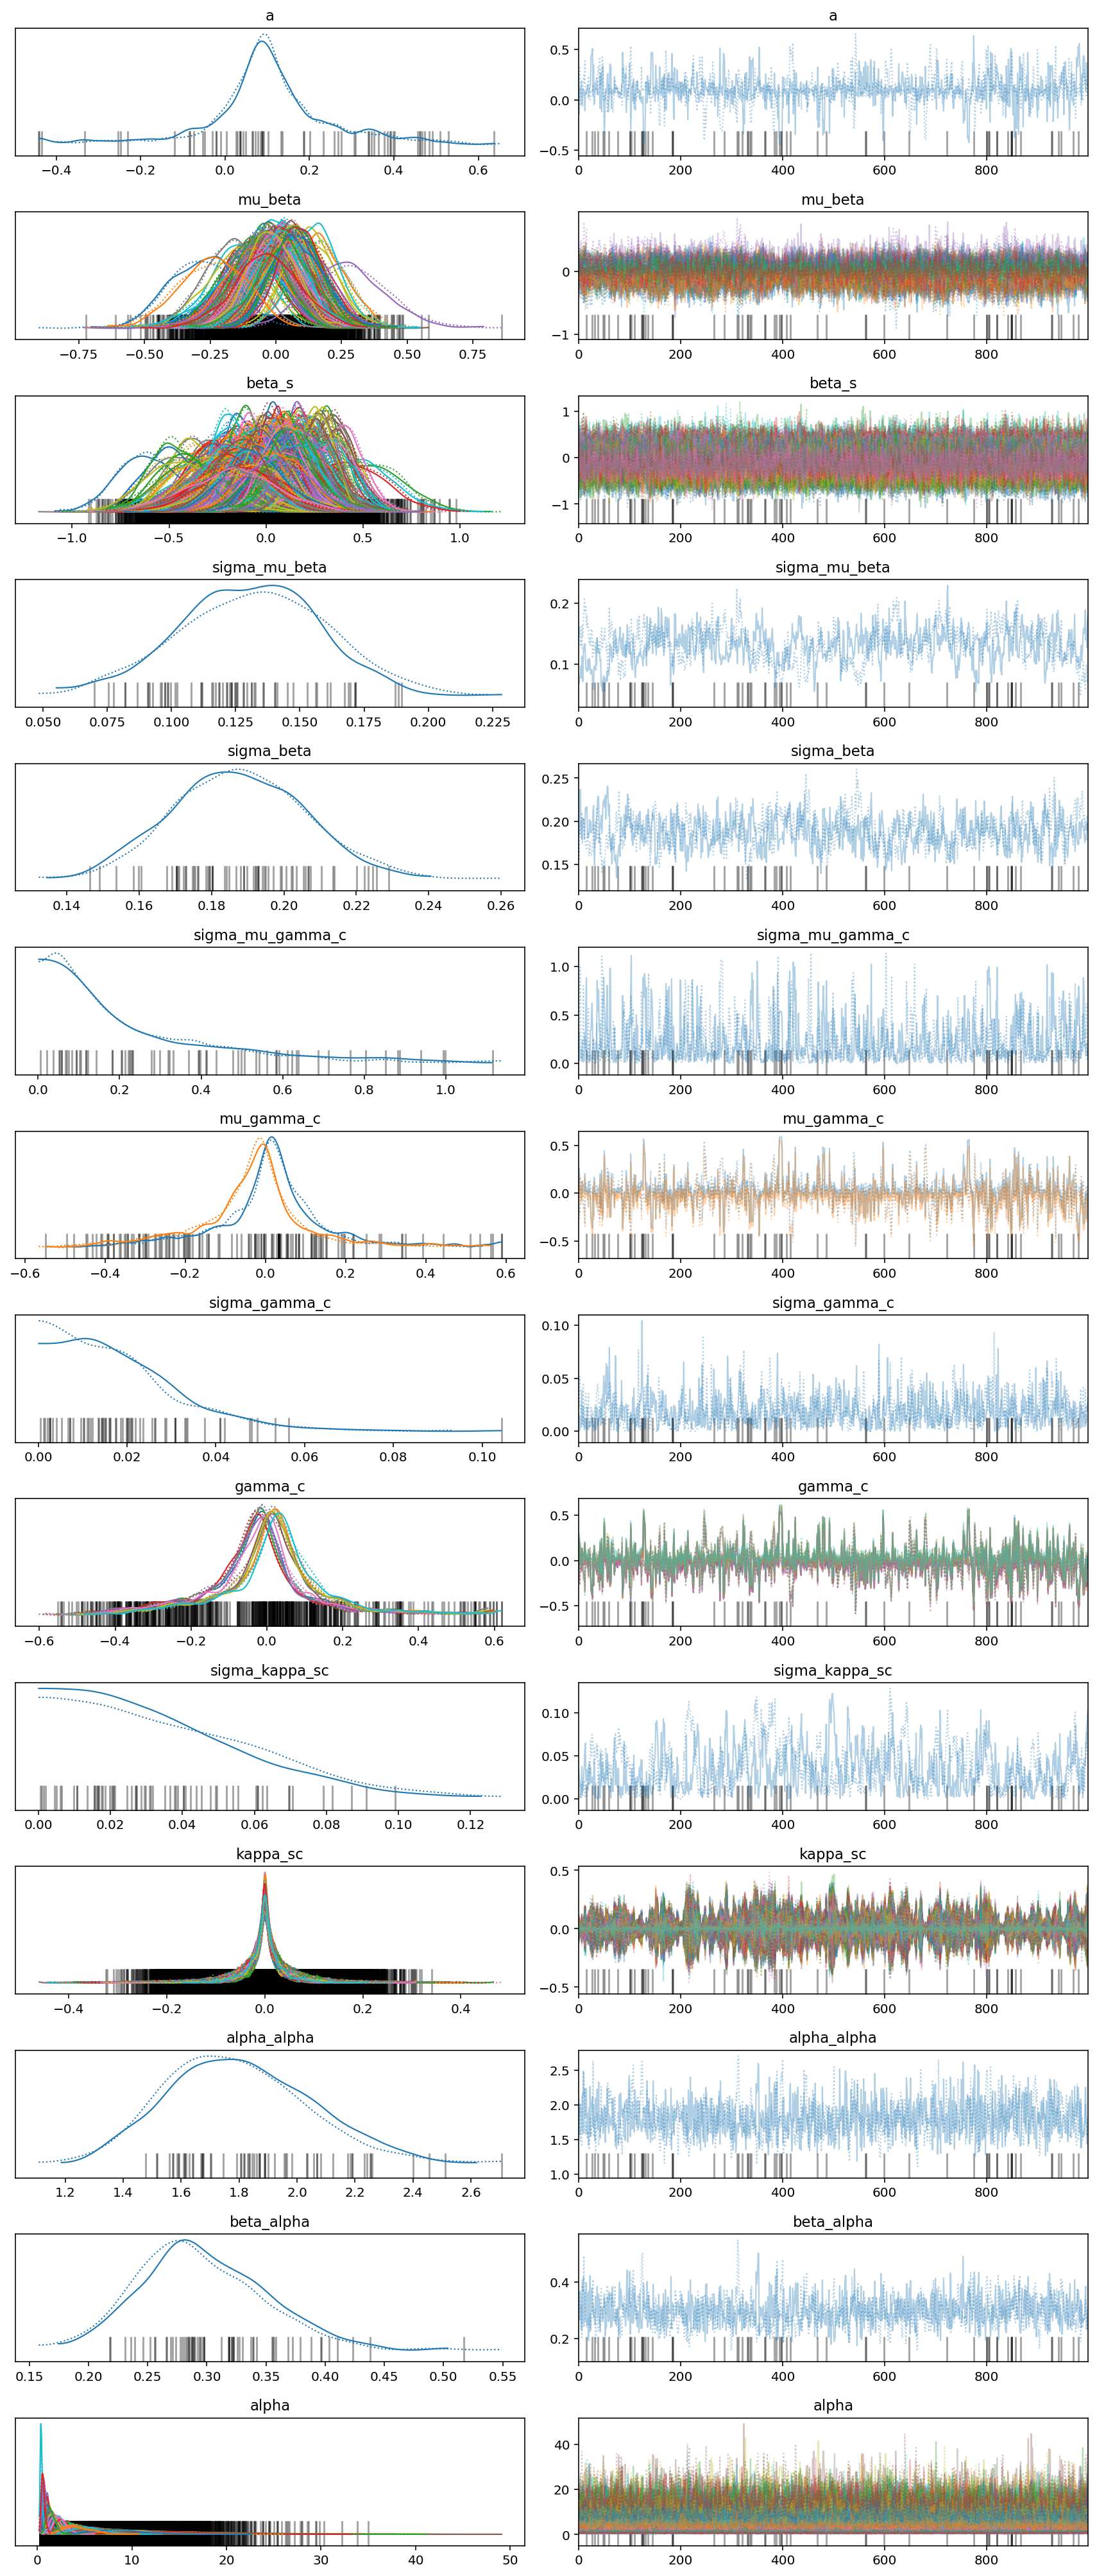

In [10]:
az.plot_trace(
    hnb_trace,
    var_names=speclet_hnb.vars_regex(ModelFitMethod.PYMC3_MCMC),
    filter_vars="regex",
)
plt.tight_layout();

In [11]:
mu_beta_post = az.summary(
    hnb_trace, var_names=["mu_beta"], hdi_prob=HDI_PROB, kind="stats"
).assign(hugo_symbol=hnb_trace.posterior.coords["gene"])

sgrna_to_gene_map = valid_data[["hugo_symbol", "sgrna"]].drop_duplicates()
beta_s_post = (
    az.summary(hnb_trace, var_names=["beta_s"], hdi_prob=HDI_PROB, kind="stats")
    .assign(sgrna=hnb_trace.posterior.coords["sgrna"])
    .merge(sgrna_to_gene_map, on="sgrna")
)

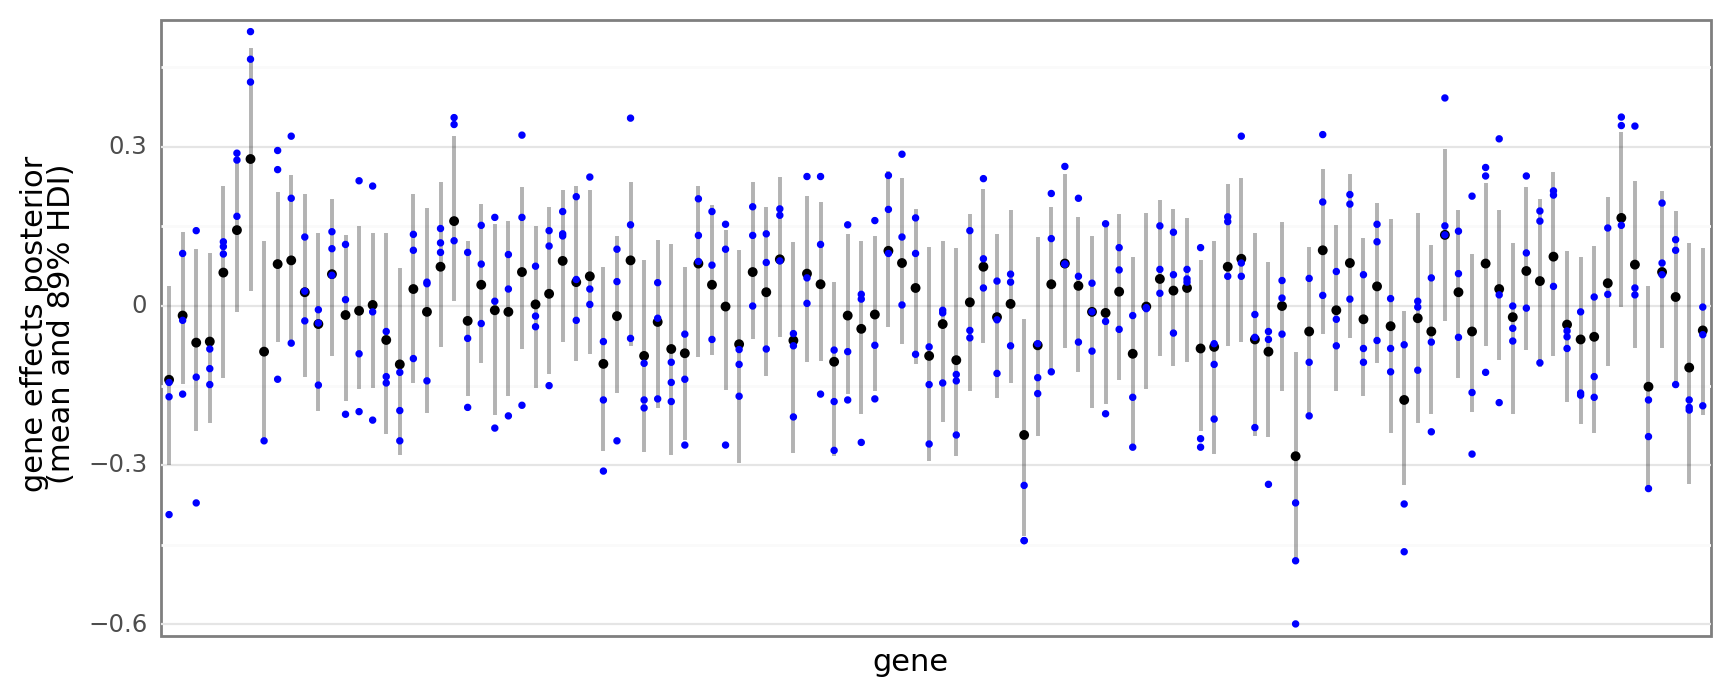

<ggplot: (376505242)>

In [12]:
(
    gg.ggplot(mu_beta_post, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.3, size=0.8)
    + gg.geom_point(size=1)
    + gg.geom_point(data=beta_s_post, size=0.5, color="blue")
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(10, 4),
        panel_grid_major_x=gg.element_blank(),
    )
    + gg.labs(x="gene", y=f"gene effects posterior\n(mean and {HDI_LBL} HDI)")
)

In [13]:
mu_gamma_post = az.summary(
    hnb_trace, var_names=["mu_gamma_c"], hdi_prob=HDI_PROB, kind="stats"
).assign(lineage=hnb_trace.posterior.coords["lineage"])
cellline_to_lineage_map = valid_data[["depmap_id", "lineage"]].drop_duplicates()
gamma_post = (
    az.summary(hnb_trace, var_names=["gamma_c"], hdi_prob=HDI_PROB, kind="stats")
    .assign(depmap_id=hnb_trace.posterior.coords["cell_line"])
    .merge(cellline_to_lineage_map, on="depmap_id")
)

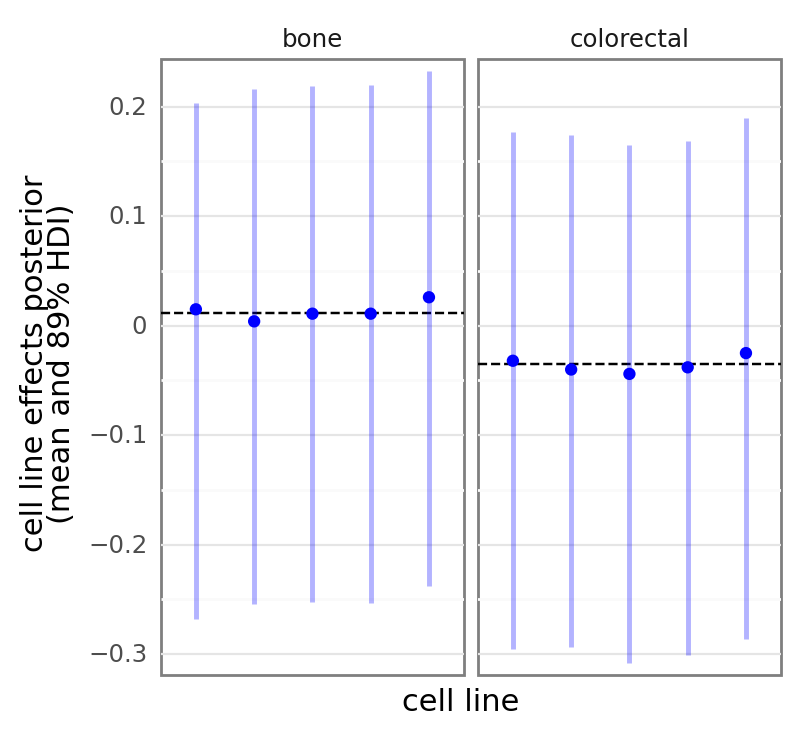

<ggplot: (375587825)>

In [14]:
(
    gg.ggplot(gamma_post, gg.aes(x="depmap_id", y="mean"))
    + gg.facet_wrap("~lineage", nrow=1, scales="free_x")
    + gg.geom_hline(gg.aes(yintercept="mean"), data=mu_gamma_post, linetype="--")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.3, size=1, color="blue"
    )
    + gg.geom_point(size=1.5, color="blue")
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(4, 4),
        panel_grid_major_x=gg.element_blank(),
    )
    + gg.labs(x="cell line", y=f"cell line effects posterior\n(mean and {HDI_LBL} HDI)")
)

In [15]:
def _variable_index_to_coords(
    df: pd.DataFrame, col: str, var_name: str
) -> pd.DataFrame:
    return df.assign(
        coords=lambda d: [
            x.replace(f"{var_name}[", "").replace("]", "").split(",") for x in d[col]
        ]
    )

In [16]:
kappa_post = (
    az.summary(hnb_trace, var_names=["kappa_sc"], hdi_prob=HDI_PROB, kind="stats")
    .reset_index(drop=False)
    .pipe(_variable_index_to_coords, col="index", var_name="kappa_sc")
    .assign(
        sgrna=lambda d: [x[0].strip() for x in d["coords"]],
        depmap_id=lambda d: [x[1].strip() for x in d["coords"]],
    )
    .drop(columns=["coords"])
    .merge(sgrna_to_gene_map, on="sgrna")
    .merge(cellline_to_lineage_map, on="depmap_id")
)
kappa_post.head()

index   mean     sd  hdi_5.5%  \
0  kappa_sc[AAACTTGCTGACGTGCCTGG, ACH-000007] -0.000  0.045    -0.072   
1   kappa_sc[AACAACTAACTTTGTACAT, ACH-000007] -0.004  0.043    -0.065   
2   kappa_sc[AACAGCTCGTTGTACCGCT, ACH-000007] -0.003  0.043    -0.062   
3   kappa_sc[AACCACTCGCTACCGAAGC, ACH-000007]  0.002  0.042    -0.066   
4  kappa_sc[AACGATCTCATCCTCAAAAG, ACH-000007]  0.000  0.040    -0.070   

   hdi_94.5%                 sgrna   depmap_id hugo_symbol     lineage  
0      0.061  AAACTTGCTGACGTGCCTGG  ACH-000007       USP46  colorectal  
1      0.061   AACAACTAACTTTGTACAT  ACH-000007       IMPA1  colorectal  
2      0.069   AACAGCTCGTTGTACCGCT  ACH-000007      CTNNB1  colorectal  
3      0.060   AACCACTCGCTACCGAAGC  ACH-000007       FUCA2  colorectal  
4      0.054  AACGATCTCATCCTCAAAAG  ACH-000007      ALKBH8  colorectal

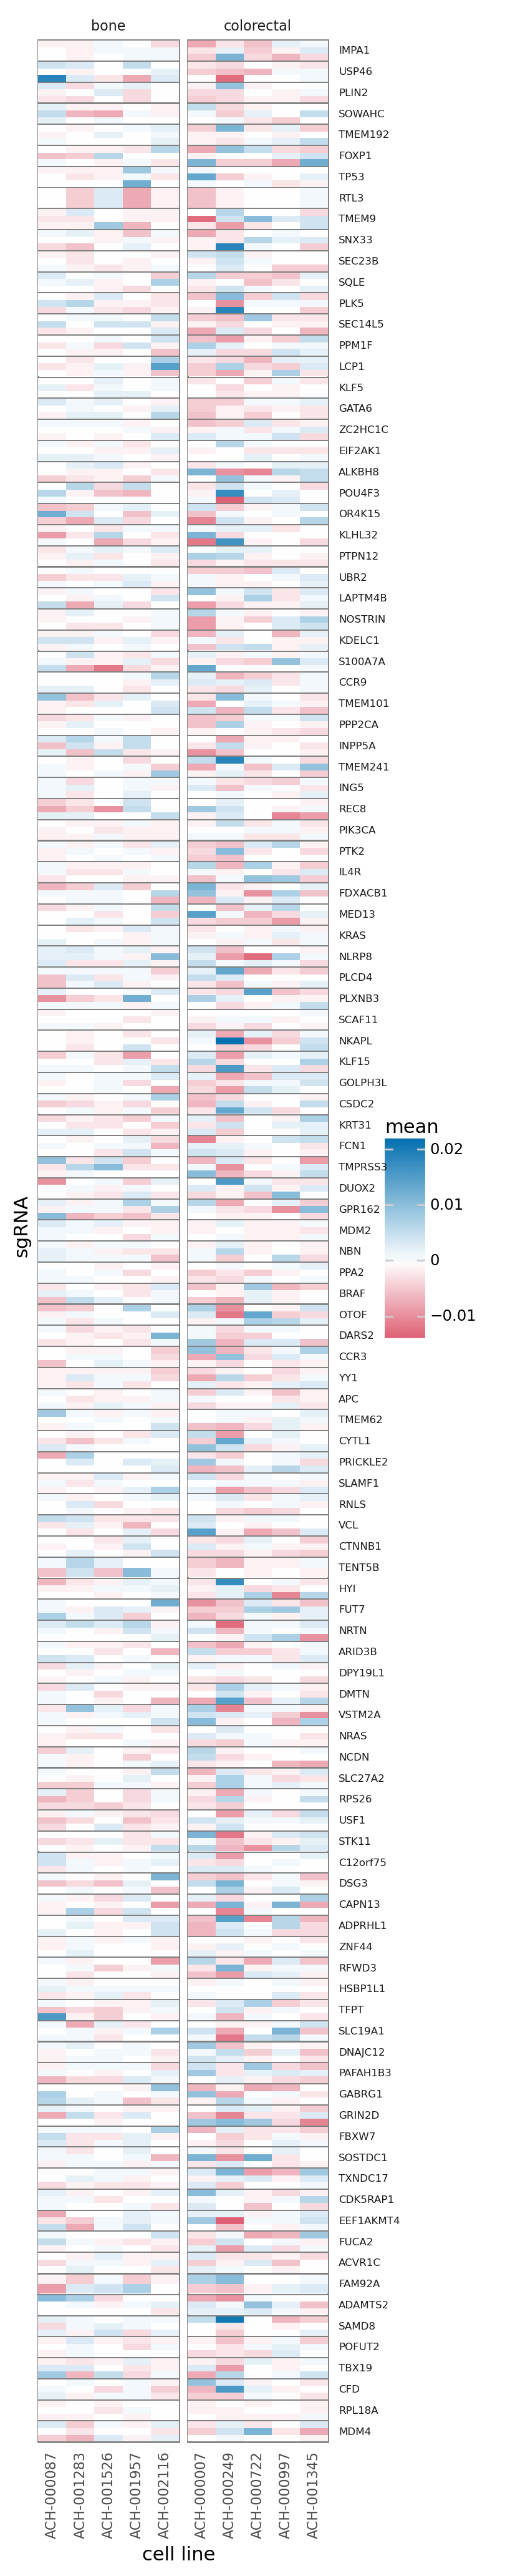

<ggplot: (375735028)>

In [17]:
(
    gg.ggplot(kappa_post, gg.aes(x="depmap_id", y="sgrna", fill="mean"))
    + gg.facet_grid("hugo_symbol ~ lineage", scales="free")
    + gg.geom_tile(color=None)
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#ca0020", mid="white", high="#0571b0", midpoint=0)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=8),
        axis_text_y=gg.element_blank(),
        figure_size=(3, 25),
        strip_text_x=gg.element_text(size=8),
        strip_text_y=gg.element_text(size=6, angle=0, hjust=0),
        subplots_adjust={"hspace": 0.0},
        panel_border=gg.element_rect(color="gray"),
        panel_grid=gg.element_blank(),
        legend_position="right",
    )
    + gg.labs(x="cell line", y="sgRNA", fill="mean")
)

In [18]:
sd_posts = az.summary(
    hnb_trace, var_names=["sigma"], filter_vars="like", hdi_prob=HDI_PROB
)
sd_posts

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
sigma_mu_beta     0.131  0.028     0.087      0.177      0.003    0.002   
sigma_beta        0.188  0.018     0.156      0.215      0.001    0.001   
sigma_mu_gamma_c  0.224  0.224     0.000      0.526      0.009    0.006   
sigma_gamma_c     0.018  0.014     0.000      0.036      0.001    0.000   
sigma_kappa_sc    0.035  0.026     0.000      0.071      0.002    0.002   

                  ess_bulk  ess_tail  r_hat  
sigma_mu_beta         91.0     249.0   1.01  
sigma_beta           285.0     452.0   1.00  
sigma_mu_gamma_c     581.0     790.0   1.00  
sigma_gamma_c        509.0     553.0   1.01  
sigma_kappa_sc       143.0     311.0   1.01

In [19]:
sd_post_draws = pd.DataFrame()
for varname in sd_posts.index.values:
    _x = hnb_trace.posterior.get(varname).values.flatten()
    _df = pd.DataFrame({"value": _x}).assign(var_name=varname)
    sd_post_draws = pd.concat([sd_post_draws, _df])

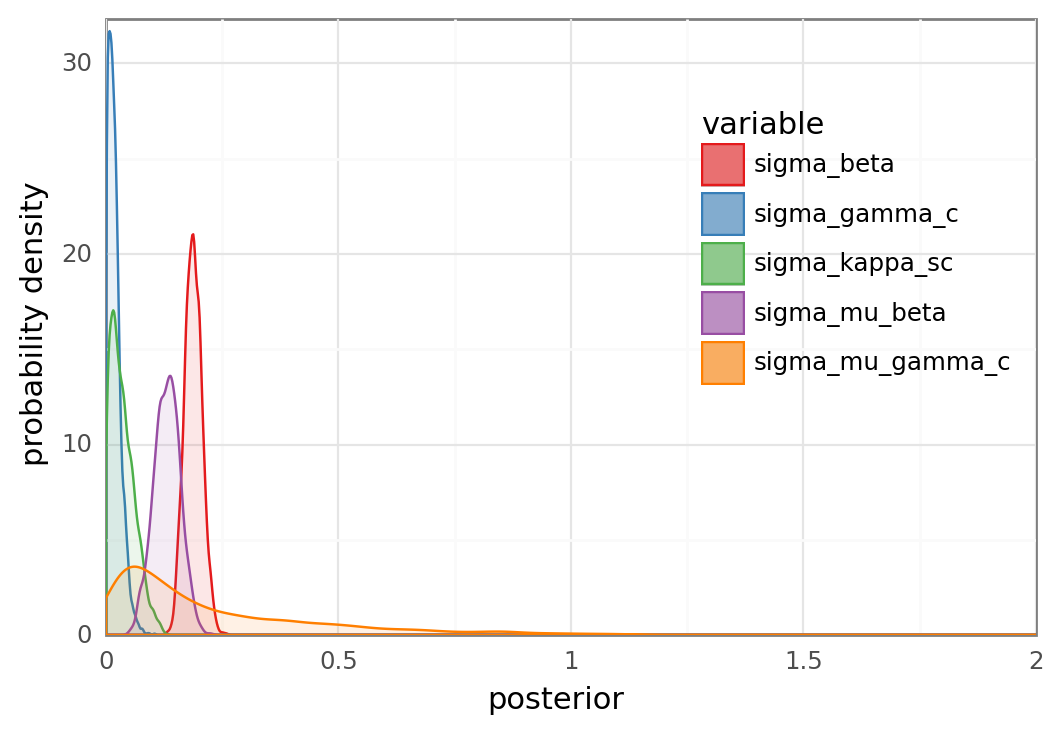

<ggplot: (353610487)>

In [20]:
(
    gg.ggplot(sd_post_draws, gg.aes(x="value", color="var_name", fill="var_name"))
    + gg.geom_density(alpha=0.1)
    + gg.scale_x_continuous(expand=(0, 0), limits=(0, 2))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", guide=gg.guide_legend(override_aes={"alpha": 0.6})
    )
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(
        figure_size=(6, 4),
        legend_position=(0.75, 0.6),
        legend_background=gg.element_blank(),
    )
    + gg.labs(x="posterior", y="probability density", color="variable", fill="variable")
)

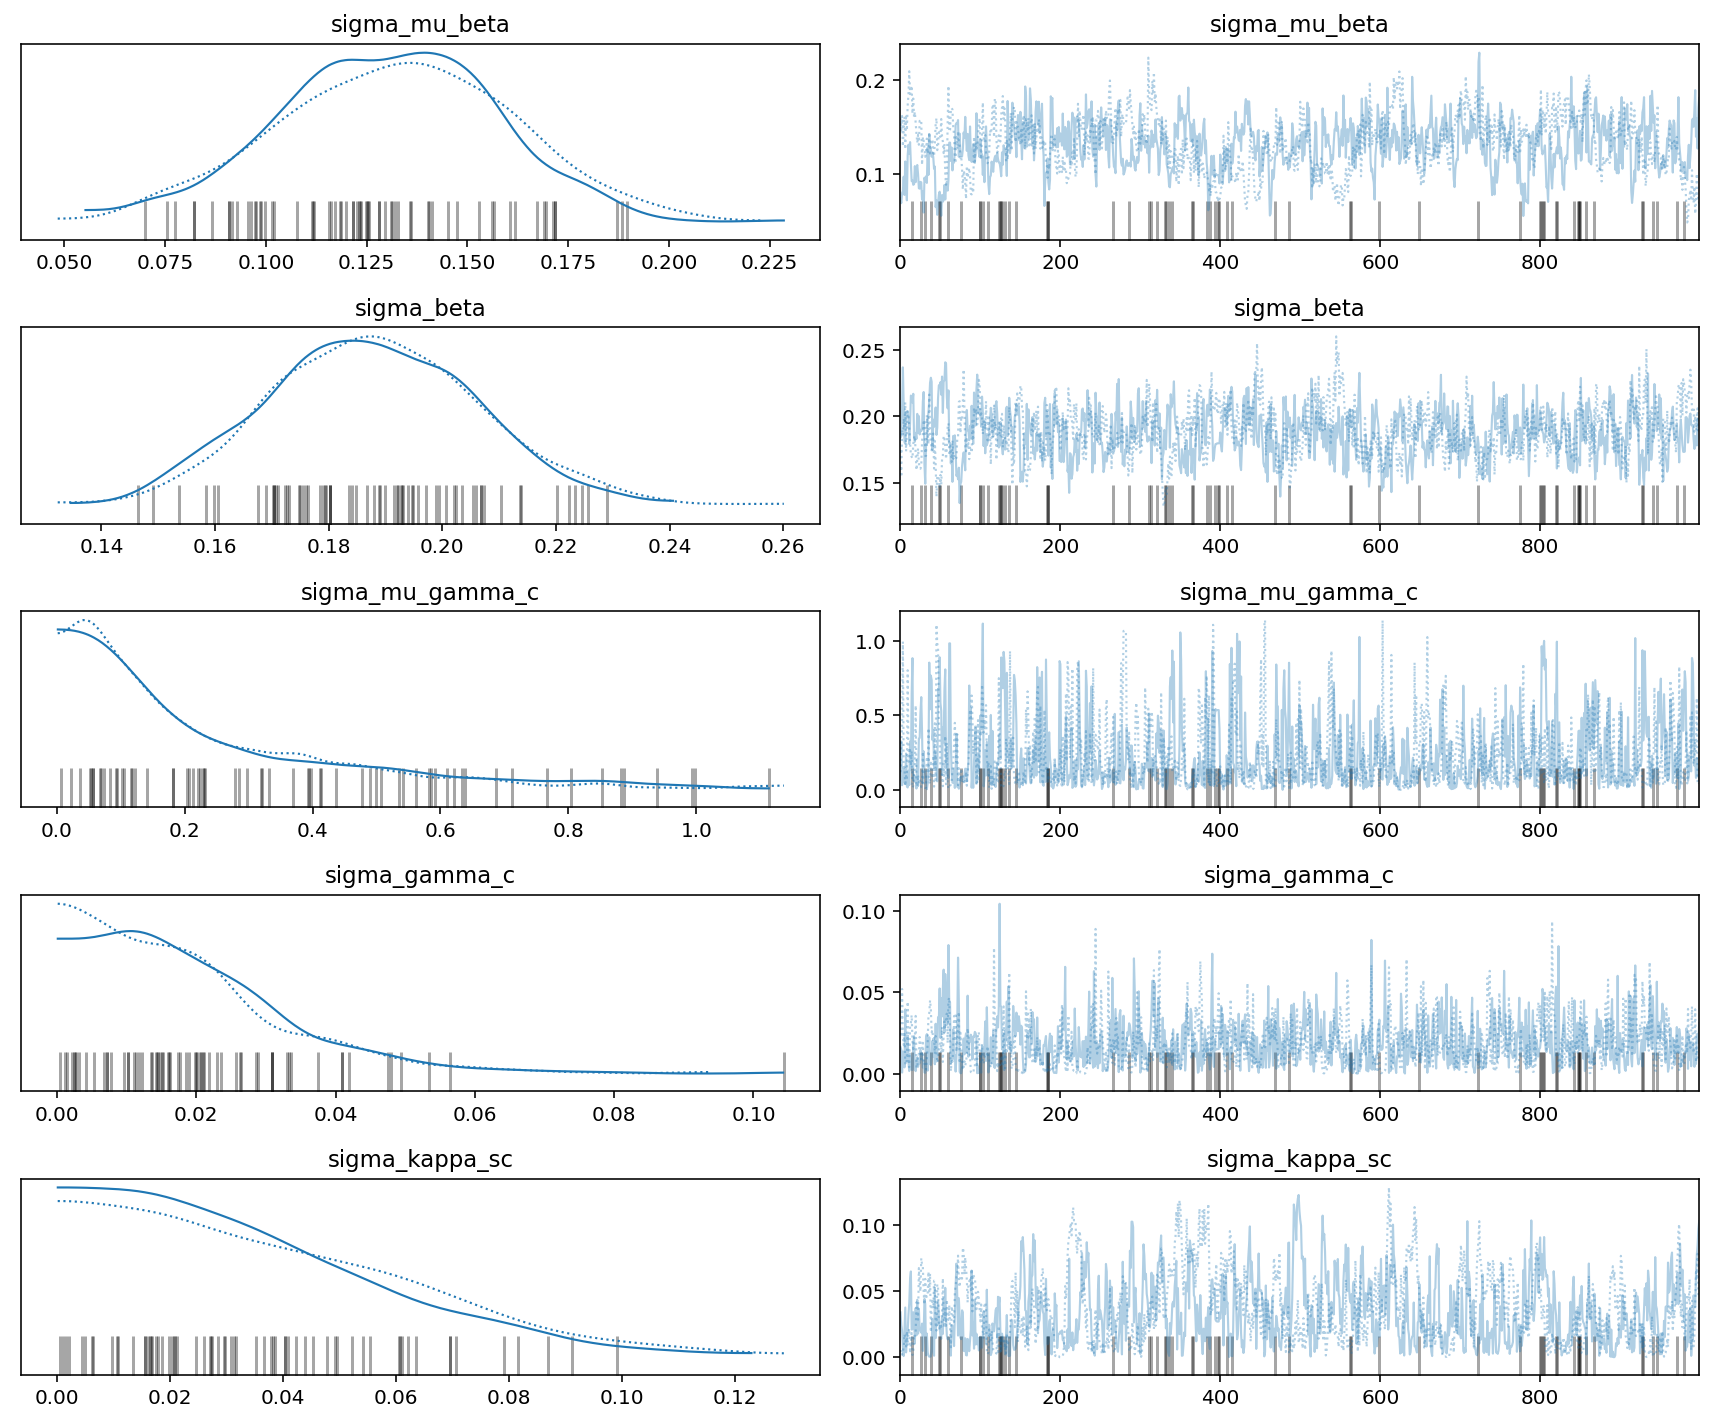

In [21]:
az.plot_trace(hnb_trace, var_names=["sigma"], filter_vars="like")
plt.tight_layout();

In [22]:
sigma_gamma_post_draws = hnb_trace.posterior["sigma_gamma_c"].values.flatten()
divergences = hnb_trace.sample_stats.diverging.values.flatten()
N_CELL_LINES = valid_data.depmap_id.nunique()
gamma_post_draws = hnb_trace.posterior["gamma_c"].values.reshape(-1, N_CELL_LINES)

gamma_post_draws_df = (
    pd.DataFrame(
        gamma_post_draws, columns=hnb_trace.posterior.coords["cell_line"].values
    )
    .assign(sigma_gamma=sigma_gamma_post_draws, divergence=divergences)
    .reset_index(drop=False)
    .pivot_longer(index=["index", "sigma_gamma", "divergence"], names_to="depmap_id")
)
gamma_post_draws_df.head()

index  sigma_gamma  divergence   depmap_id     value
0      0     0.016342       False  ACH-000007 -0.071051
1      1     0.014862       False  ACH-000007  0.212257
2      2     0.000599       False  ACH-000007 -0.037676
3      3     0.013518       False  ACH-000007 -0.018243
4      4     0.009521       False  ACH-000007  0.006166

In [23]:
def organize_group_mean_against_stddev(
    trace: az.InferenceData, sd_var: str, mu_var: str, coord: str
) -> pd.DataFrame:
    groups = trace.posterior.coords[coord].values
    sd_post_draws = trace.posterior[sd_var].values.flatten()
    divergences = trace.sample_stats.diverging.values.flatten()
    mu_post_draws = trace.posterior[mu_var].values.reshape(-1, len(groups))

    post_draws_df = (
        pd.DataFrame(mu_post_draws, columns=groups)
        .assign(__sd_var=sd_post_draws, divergence=divergences)
        .reset_index(drop=False)
        .pivot_longer(
            index=["index", "__sd_var", "divergence"], names_to=coord, values_to=mu_var
        )
        .rename(columns={"__sd_var": sd_var})
    )
    return post_draws_df


def plot_group_mean_against_stddev(
    sd_and_mu_df: pd.DataFrame, x: str, y: str, fct: str
) -> gg.ggplot:
    return (
        gg.ggplot(sd_and_mu_df.sort_values("divergence"), gg.aes(x=x, y=y))
        + gg.facet_wrap(f"~{fct}")
        + gg.geom_point(gg.aes(color="divergence"), size=0.7, alpha=0.7)
        + gg.scale_color_manual(values={True: "red", False: "k"})
    )

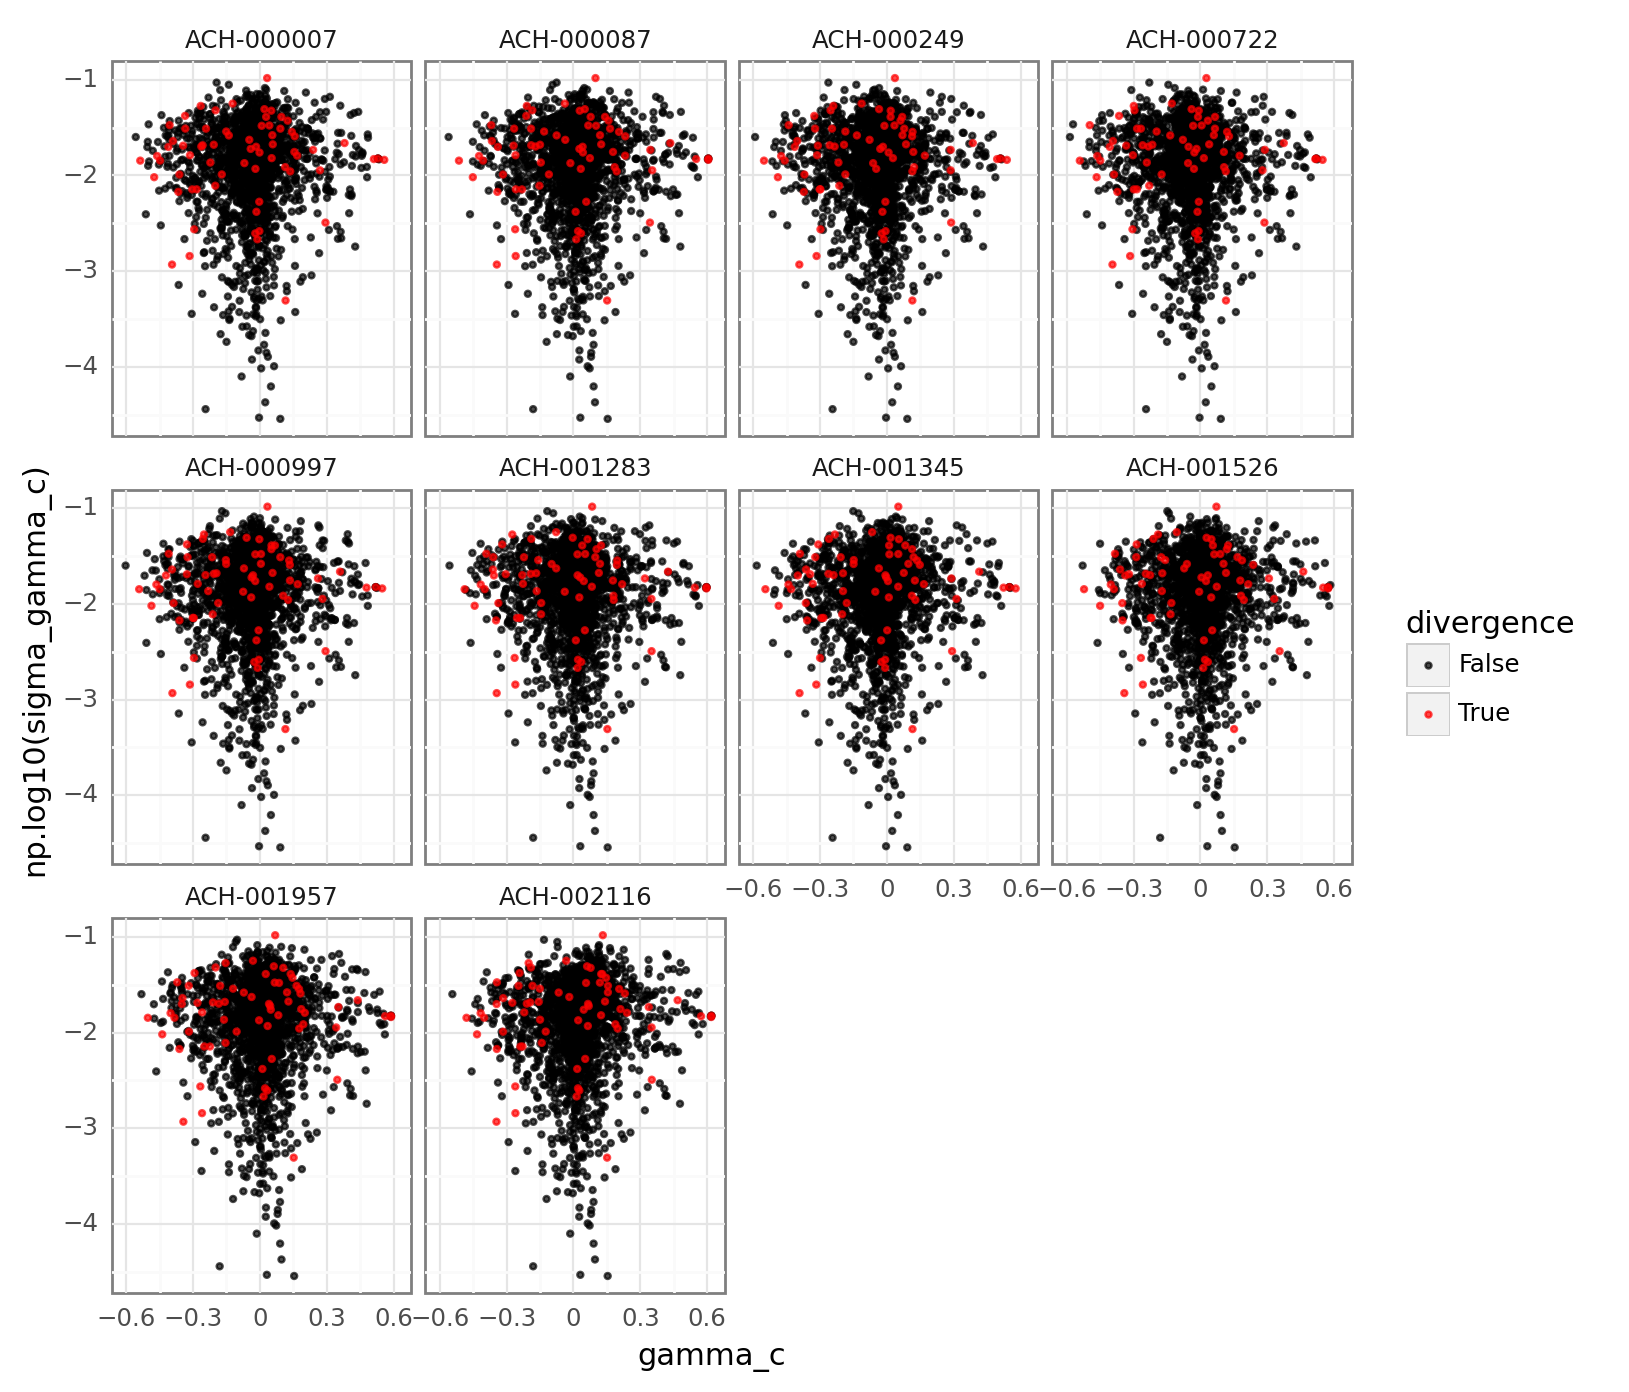

<ggplot: (354035929)>

In [24]:
gamma_post_draws_df = organize_group_mean_against_stddev(
    hnb_trace, sd_var="sigma_gamma_c", mu_var="gamma_c", coord="cell_line"
)
plot_group_mean_against_stddev(
    gamma_post_draws_df, x="gamma_c", y="np.log10(sigma_gamma_c)", fct="cell_line"
) + gg.theme(figure_size=(8, 8))

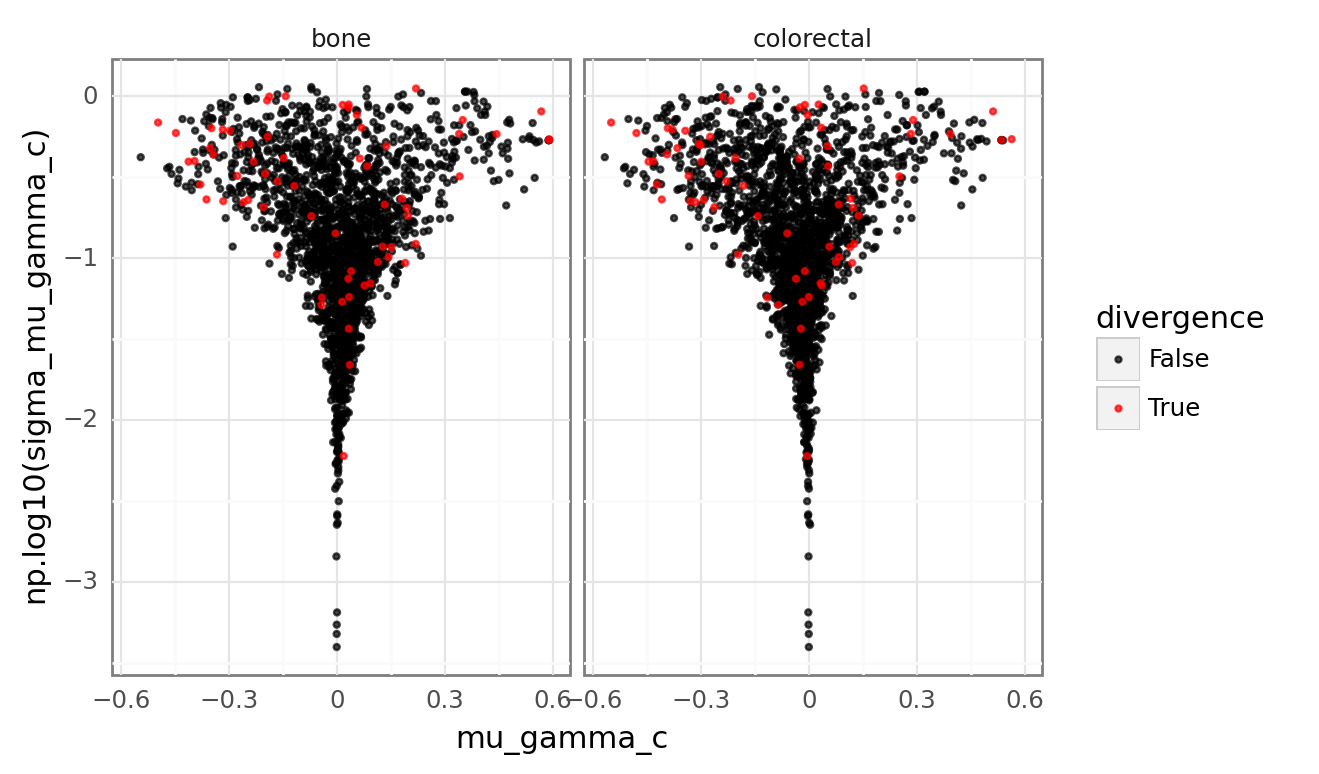

<ggplot: (354588820)>

In [25]:
mu_gamma_post_draws_df = organize_group_mean_against_stddev(
    hnb_trace, sd_var="sigma_mu_gamma_c", mu_var="mu_gamma_c", coord="lineage"
)
(
    plot_group_mean_against_stddev(
        mu_gamma_post_draws_df,
        x="mu_gamma_c",
        y="np.log10(sigma_mu_gamma_c)",
        fct="lineage",
    )
    + gg.theme(figure_size=(6, 4))
)

### Posterior predictive check

In [26]:
hnb_ppc = hnb_trace.posterior_predictive["ct_final"].values.reshape(
    -1, valid_data.shape[0]
)
hnb_ppc.shape

(2000, 2188)

In [27]:
hnb_ppc_sample = (
    pd.DataFrame(hnb_ppc[::80, :].T)
    .reset_index(drop=False)
    .rename(columns={"index": "data_idx"})
    .pivot_longer(index="data_idx", names_to="ppc_draw", values_to="counts_final")
)
print(f"num. examples: {len(hnb_ppc_sample.ppc_draw.unique())}")

hnb_ppc_avg = pd.DataFrame({"counts_final": np.median(hnb_ppc, axis=0)})
ppc_hdi = az.hdi(hnb_ppc, hdi_prob=HDI_PROB)
hnb_ppc_avg["hdi_low"] = ppc_hdi[:, 0]
hnb_ppc_avg["hdi_hi"] = ppc_hdi[:, 1]

plt_df = pd.concat(
    [
        hnb_ppc_sample.assign(lbl="PP draw"),
        hnb_ppc_avg[["counts_final"]].assign(lbl="PP avg.", ppc_draw="PP avg."),
        valid_data[["counts_final"]].assign(lbl="obs.", ppc_draw="obs."),
    ]
)
plt_df.head()

num. examples: 25


/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_1541/295761941.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


data_idx ppc_draw  counts_final      lbl
0       0.0        0          73.0  PP draw
1       1.0        0         509.0  PP draw
2       2.0        0         268.0  PP draw
3       3.0        0         458.0  PP draw
4       4.0        0         212.0  PP draw

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 752 rows containing non-finite values.


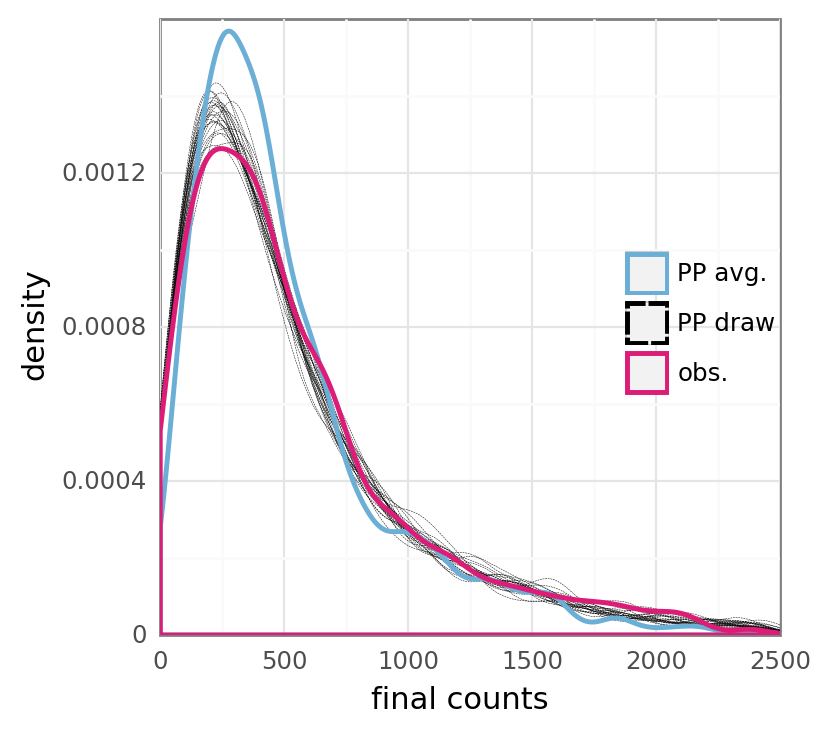

<ggplot: (354983446)>

In [28]:
(
    gg.ggplot(plt_df, gg.aes(x="counts_final", color="lbl", group="ppc_draw"))
    + gg.geom_density(gg.aes(size="lbl", linetype="lbl"), alpha=0)
    + gg.scale_x_continuous(expand=(0, 0), limits=(0, 2500))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_manual(
        values={"PP draw": "k", "PP avg.": "#6baed6", "obs.": "#dd1c77"},
        guide=gg.guide_legend(override_aes={"size": 1, "fill": "white"}),
    )
    + gg.scale_size_manual(values={"PP draw": 0.1, "PP avg.": 1, "obs.": 1})
    + gg.scale_linetype_manual(values={"PP draw": "--", "PP avg.": "-", "obs.": "-"})
    + gg.theme(
        legend_title=gg.element_blank(),
        legend_position=(0.8, 0.5),
        legend_background=gg.element_blank(),
    )
    + gg.labs(x="final counts", y="density")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_smooth : Removed 2 rows containing missing values.


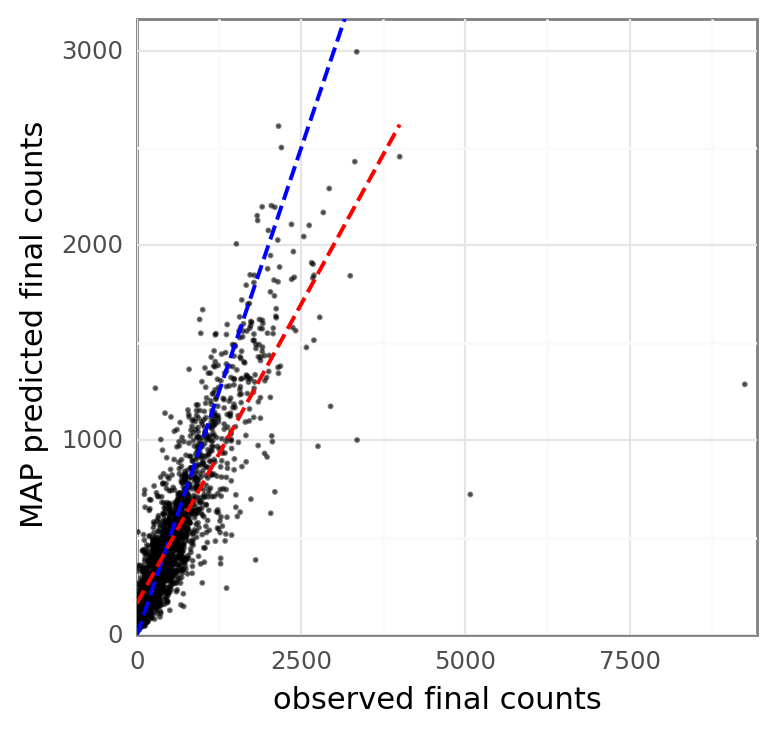

<ggplot: (355207129)>

In [29]:
plt_df = (
    valid_data.copy()
    .assign(
        ppc_avg=hnb_ppc_avg.counts_final,
        hdi_low=hnb_ppc_avg.hdi_low,
        hdi_hi=hnb_ppc_avg.hdi_hi,
    )
    .reset_index(drop=False)
)
(
    gg.ggplot(plt_df, gg.aes(x="counts_final", y="ppc_avg"))
    + gg.geom_point(size=0.2, alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color="blue", size=0.8)
    + gg.geom_smooth(
        formula="y~x", method="lm", linetype="--", color="red", size=0.8, se=False
    )
    + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(0, 3100))
    + gg.labs(x="observed final counts", y="MAP predicted final counts")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 372 rows containing missing values.


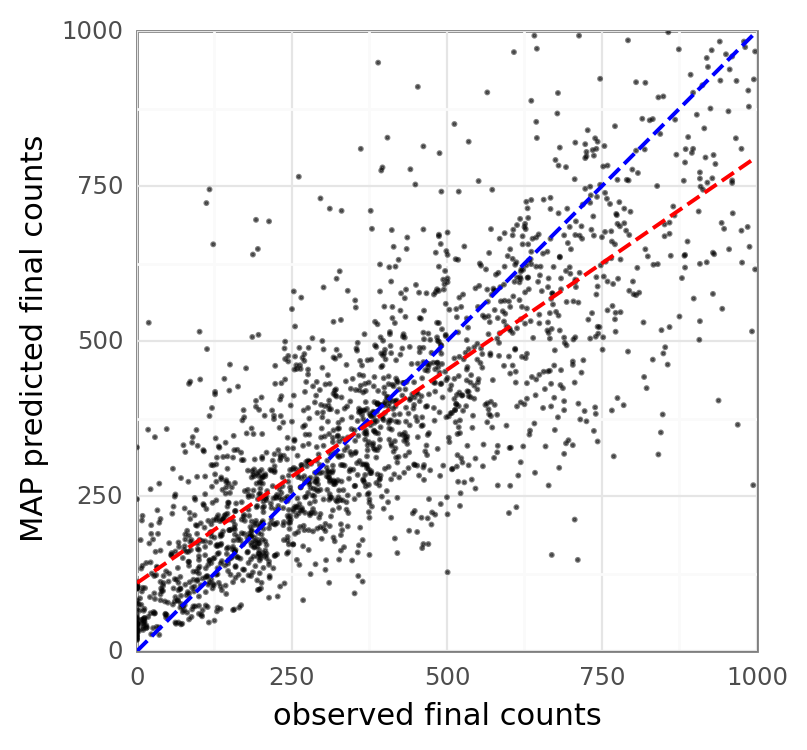

<ggplot: (354564106)>

In [30]:
(
    gg.ggplot(plt_df, gg.aes(x="counts_final", y="ppc_avg"))
    + gg.geom_point(size=0.2, alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, linetype="--", color="blue", size=0.8)
    + gg.geom_smooth(
        formula="y~x", method="lm", linetype="--", color="red", size=0.8, se=False
    )
    + gg.scale_x_continuous(expand=(0, 0), limits=(0, 1000))
    + gg.scale_y_continuous(expand=(0, 0), limits=(0, 1000))
    + gg.coord_equal()
    + gg.labs(x="observed final counts", y="MAP predicted final counts")
)

---

In [31]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.52 minutes


In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-26

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: nb-model

arviz     : 0.11.4
pandas    : 1.3.5
seaborn   : 0.11.2
speclet   : 0.0.9000
janitor   : 0.22.0
numpy     : 1.22.0
matplotlib: 3.5.1
plotnine  : 0.8.0

